In [25]:
from torch.utils.data import random_split, SubsetRandomSampler, Subset
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, wilcoxon, mannwhitneyu
import pandas as pd
from tqdm import tqdm
from deepsig import aso, bootstrap_test, permutation_test
from random import sample
import random
CONSIDERED_TESTS = {
    "ASO": lambda a, b: aso(a, b, show_progress=False),
    "Student's t": lambda a, b: ttest_ind(a, b, equal_var=False, alternative="greater")[
        1
    ],
    "Bootstrap": lambda a, b: bootstrap_test(a, b),
    "Permutation": lambda a, b: permutation_test(a, b),
    "Wilcoxon": lambda a, b: wilcoxon(a, b, alternative="greater").pvalue,
    "Mann-Whitney U": lambda a, b: mannwhitneyu(a, b, alternative="greater").pvalue,
}

SAMPLE_SIZES = [5, 10, 15, 20]
MEAN_DIFFS = [0.25, 0.5, 0.75, 1]
SAVE_DIR = "./img"
NUM_SIMULATIONS = {
    "ASO": 500,
    "Student's t": 1000,
    "Bootstrap": 1000,
    "Permutation": 1000,
    "Wilcoxon": 1000,
    "Mann-Whitney U": 1000,
}
P_VALUE_TRESHOLD = 0.05
ASO_THRESHOLD = 0.2
ALL_THRESHOLDS = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
DISTRIBUTIONS = {
    "NORMAL": lambda n, mu, sigma, scale: np.random.normal(mu, sigma, n),
    "LAPLACE": lambda n, mu, sigma, scale: np.random.laplace(mu, scale, n),
    "RAYLEIGH": lambda n, mu, sigma, scale: np.random.rayleigh(scale, n)
}

def normal_mixture(
    loc: float,
    scale: float,
    size: int,
    loc2: float = -0.5,
    scale2: float = 0.25,
    mixture_coeff: float = 0.7,
):
    """
    Define a simple sampling procedure from a mixture of two normal distributions.
    """
    samples1 = np.random.normal(
        loc=loc, scale=scale, size=int(size * mixture_coeff)
    )
    samples2 = np.random.normal(
        loc=loc2, scale=scale2, size=size - int(size * mixture_coeff)
    )
    combined_samples = np.concatenate((samples1, samples2))
    return combined_samples

In [26]:
def compute_stats(scores, stats_dict):
    #Takes in sets of scores, performs various statistical testing 
    #Output is 2d array, type of test on one axis and sample size on the other
    for samp_size in SAMPLE_SIZES:
        scores1 = sample(list(scores[0]),samp_size)
        scores2 = sample(list(scores[1]),samp_size)
        samp_size_scores = []
        iter = 0
        for key in CONSIDERED_TESTS:
            pval = CONSIDERED_TESTS[key](scores1, scores2)
            stats_dict[samp_size][iter].append(pval)
            iter += 1
        
    return stats_dict

In [30]:
def get_scores(n, dist, mu = 0, scale = 0, sigma = 0):
    #Takes in models and data, performs 40 bootstrap samples (20 for each model)
    #Returns two lists of scores (list of list)
    scores1 = DISTRIBUTIONS[dist](n, mu, sigma, scale)
    
    scores2 = DISTRIBUTIONS[dist](n, mu = .5, sigma = 1.5, scale = scale)
    
    scores = [scores1, scores2]
    return scores

In [16]:
def get_scores_mixture(loc, scale, size):
    #Takes in models and data, performs 40 bootstrap samples (20 for each model)
    #Returns two lists of scores (list of list)
    scores1 = normal_mixture(loc, scale, size)
    
    scores2 = normal_mixture(loc, scale, size)
    
    scores = [scores1, scores2]
    return scores

In [28]:
def make_statistics(nloops):
    #full_data_X and full_data_y must be two numpy arrays
    stats_dict = {
    5: [[], [], [], [], [], []],
    10: [[], [], [], [], [], []],
    15: [[], [], [], [], [], []],
    20: [[], [], [], [], [], []]
    }
    for i in range(0, nloops):
        if i % 10 == 0:
            print(i)
        scores = get_scores(n =20, dist = "NORMAL", mu = 0, sigma = 1.5)
        #scores = get_scores_mixture(loc = 2.5, scale = 1, size = 20)
        stats_dict = compute_stats(scores, stats_dict)
    return(stats_dict)

In [31]:
stats = make_statistics(750)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


In [20]:
#save stats to json file
import json
with open('stats_mixture.json', 'w') as fp:
    json.dump(stats, fp)

    

In [21]:
#for each sample size, calculate the type 1 error rate in stats for each test
type1error_dict = {
    5: [],
    10: [],
    15: [],
    20: []
}

for key in stats.keys():
    for j in range(0, 6):
        count = 0
        for k in range(0, 750):
            if j == 0:
                if stats[key][j][k] < 0.2:
                    count += 1
            else:
                if stats[key][j][k] < 0.05:
                    count += 1
                
            
        type1error_dict[key].append(count/750) 

In [22]:
#restructure data for line plotting
type1error_dict = pd.DataFrame(type1error_dict)
type1error_dict = type1error_dict.transpose()
type1error_dict.columns = ["ASO", "Student's t", "Bootstrap", "Permutation", "Wilcoxon", "Mann-Whitney U"]
type1error_dict = type1error_dict.reset_index()
type1error_dict = type1error_dict.rename(columns = {"index": "Sample Size"})
type1error_dict = type1error_dict.melt(id_vars = ["Sample Size"], var_name = "Test", value_name = "Type 1 Error Rate")



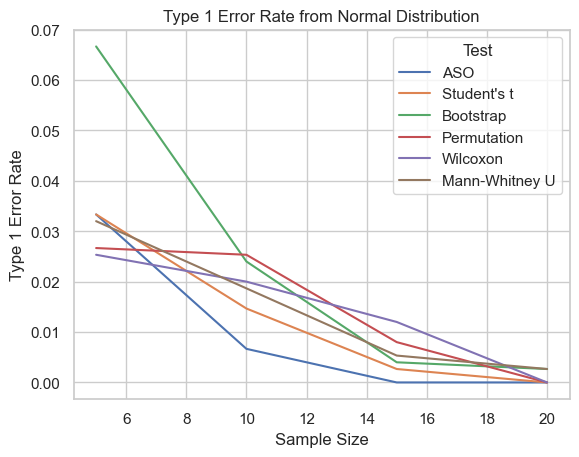

In [23]:
#plot type 1 error rate
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.lineplot(x="Sample Size", y="Type 1 Error Rate", hue="Test", data=type1error_dict)
ax.set_title("Type 1 Error Rate from Normal Distribution")
ax.set(xlabel='Sample Size', ylabel='Type 1 Error Rate')
plt.savefig("type1error_mixture.png")

